In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv(r"C:\Users\pedro\OneDrive\Documentos\fraude\2\AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
df.shape

(6362620, 11)

In [13]:
porcentagem_fraudes = (df["isFraud"].value_counts()[1] / df.shape[0]) * 100
porcentagem__nao_fraudes = (df["isFraud"].value_counts()[0] / df.shape[0]) * 100

print(
    f"""
        Porcentagem de fraudes: {porcentagem_fraudes}
        Porcentagem não fraudes: {porcentagem__nao_fraudes}
    """
)


        Porcentagem de fraudes: 0.12908204481801522
        Porcentagem não fraudes: 99.87091795518198
    


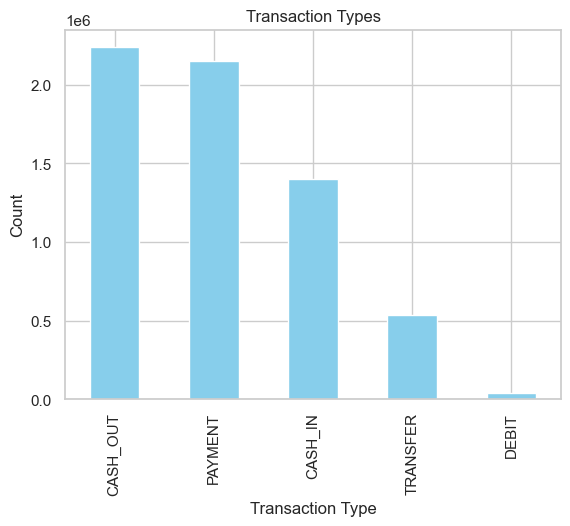

In [ ]:
# Visualizando os meios de pagamentos mais comuns

df["type"].value_counts().plot(kind="bar", title="Transaction Types", color="skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

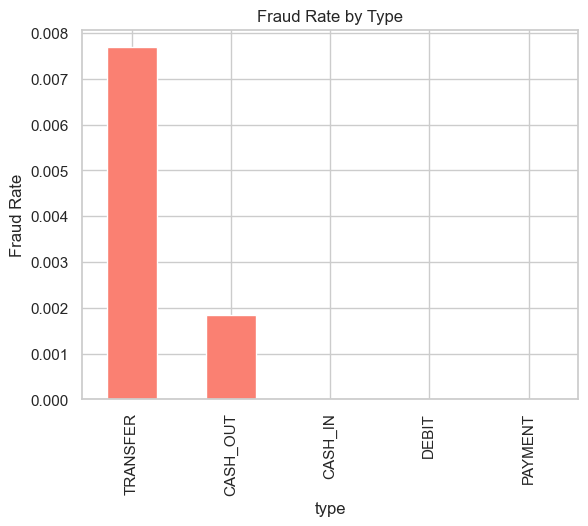

In [ ]:
# Visualizando quais meios de pagamentos tem mais fraudes

fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar", title="Fraud Rate by Type", color="salmon")
plt.ylabel("Fraud Rate")
plt.show()

In [16]:
df.drop(columns="step", inplace=True)

In [17]:
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()

In [18]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


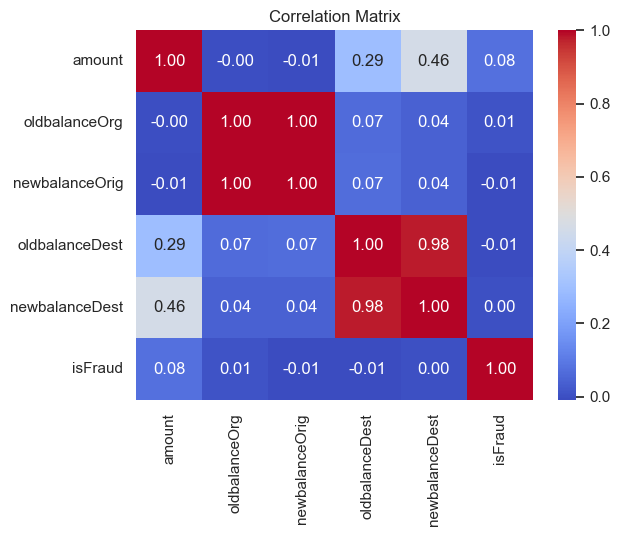

In [19]:
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [21]:
df_model = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis = 1)

In [22]:
categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

In [23]:
y = df_model["isFraud"]
X = df_model.drop("isFraud", axis = 1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [26]:
# Preparação das informações para a realização do treinamento do modelo

# StandarScaler deixa tudo na mesma escala padronizando os valores com média 0 e desvio padrao 1. Significa que os dados vão variar em torno do 0
# OneHotEnconder é transformar as informações de texto em numeros binários, por exemplo "Sim" e "Não" que vão ser transformado em 1 e 0

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

In [27]:
# Na hora que for fazer o treinamento o pipeline vai ser chamado, e assim vai ser executado a transformação dos dados e já vai ser feito regressão logistica
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [30]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.95      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [31]:
confusion_matrix(y_test, y_pred)

array([[1804583,  101739],
       [    125,    2339]], dtype=int64)

Calculo da acurácia

In [32]:
pipeline.score(X_test, y_test)

0.9466341433769946

Salvando o modelo

In [33]:
import joblib

joblib.dump(pipeline, "fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']